In [5]:
import sys
sys.path.append('.././')

In [6]:
import warnings
import os
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt 

from geonetworkx.tools import get_alpha_shape_polygon
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.errors import ShapelyDeprecationWarning

from app.utils import plug_shape_holes, grid_interpolate, colorize_image, convert_image_to_bytes_url, get_gdf_corners, \
    prepare_interpolation_points, extract_contours_from_singleband_raster
from app.utils import PALETTE

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [7]:
# center = [45.503032, -73.566424]
center = [45.5180153236 , -73.5608482361]
source_ = center
colormap = plt.cm.YlOrRd
padding_geo = 1 / 111111 * 10
padding = 10
offset = 50

alpha = 85
plug_holes = False
force_single = False

distance = 500
interval = 100
cell_size = 5

cap_style = 'square'

# algo = 'idw'
algo = 'tin'

In [8]:
# Build the graph
graph = ox.graph_from_point(source_, network_type='walk', dist=distance + 250)
nodes, edges = ox.utils_graph.graph_to_gdfs(graph)

# Get UTM crs for distance based geoprocessing
utm_crs = nodes.estimate_utm_crs()

# Construct GeoDataFrames
source = gpd.GeoDataFrame(geometry=[Point(source_[::-1])], crs='epsg:4326')
buffer = source.to_crs(utm_crs).buffer(distance).to_crs('epsg:4326')

# Merge source to graph
# gnx.spatial_points_merge(graph, source, inplace=True)

# Clip
nodes = nodes.clip(buffer)
edges = edges.clip(buffer)

# Find the closest node to source_
start_node = ox.nearest_nodes(graph, source_[1], source_[0])

# Get start node as gdf for plotting
start_point = nodes[nodes.index == start_node].copy()

C:\Users\arthu\miniconda3\envs\mybase\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [9]:
# Calculate isochrone
subgraph = nx.ego_graph(graph, start_node, radius=distance, distance='length')
acc_nodes, acc_edges = ox.utils_graph.graph_to_gdfs(subgraph)

# Convex shape
# shape_convex_raw = acc_nodes.unary_union.convex_hull
# shape_convex_raw = gpd.GeoSeries([shape_convex_raw], crs='epsg:4326')
shape_convex = acc_nodes.unary_union.convex_hull.buffer(padding_geo)
shape_convex_df = gpd.GeoDataFrame(geometry=[shape_convex], crs='epsg:4326')
shape_convex_area = round(shape_convex_df.to_crs(utm_crs).iloc[0].geometry.area / 1000000, 2)

# Concave shape
pts = list(acc_nodes.to_crs(utm_crs).geometry.apply(lambda p: (p.x, p.y)))
shape_concave = get_alpha_shape_polygon(pts, alpha)

# Concave shape - CONDITION - no holes
if plug_holes:
    shape_concave = plug_shape_holes(shape_concave)

# Concave shape - CONDITION - single part geometry
if force_single:
    while shape_concave.geom_type.lower() == 'multipolygon':
        if new_alpha == 100:
            break
        new_alpha += 1

        # with st.empty():
        #     st.write('Overwritten alpha percentile:', new_alpha)

        shape_concave = get_alpha_shape_polygon(pts, new_alpha)
        if plug_holes:
            shape_concave = plug_shape_holes(shape_concave)

shape_concave = shape_concave.buffer(padding)
shape_concave_area = round(shape_concave.area / 1000000)
shape_concave_df = gpd.GeoDataFrame(geometry=[shape_concave], crs=utm_crs).to_crs(
    'epsg:4326')

# Offset shape
shape_offset = acc_edges.to_crs(utm_crs).buffer(offset, cap_style=cap_style).unary_union
shape_offset_area = round(shape_offset.area / 1000000)
shape_offset_df = gpd.GeoDataFrame(geometry=[shape_offset], crs=utm_crs).to_crs(
    'epsg:4326')

In [10]:
# Prepare points layer with column with values to interpolate
node_dists = prepare_interpolation_points(subgraph, start_node, acc_nodes, colormap)
node_dists.to_crs(utm_crs)[['dist', node_dists.geometry.name]].to_file('pts.geojson', driver='GeoJSON')

# Perform the interpolation
img_singleband_idw, ds = grid_interpolate(node_dists, buffer.to_crs(utm_crs), cell_size, algo='idw')
cmd = f"gdal_grid -l pts -a invdist:power=3.0:smoothing=0.0:radius1=0.0:radius2=0.0:angle=0.0:max_points=0:min_points=0:nodata=0.0 -zfield dist pts.geojson gdal_idw.tif"
os.system(cmd)
cmd = f'gdal_contour -a dist -i {interval} gdal_idw.tif gdal_idw_contour.geojson'
os.system(cmd)

img_singleband_tin, ds = grid_interpolate(node_dists, buffer.to_crs(utm_crs), cell_size, algo='tin')
cmd = f"gdal_grid -l pts -a linear:nodata=0.0 -zfield dist pts.geojson gdal_tin.tif"
os.system(cmd)
cmd = f'gdal_contour -a dist -i {interval} gdal_tin.tif gdal_tin_contour.geojson'
os.system(cmd)

0

In [11]:
# Colorize and get RGBA uint8 image
img_rgba_idw = colorize_image(img_singleband_idw, colormap=colormap)
img_rgba_tin = colorize_image(img_singleband_tin, colormap=colormap)

# Convert image to encoded bytes
# img_rgba_encoded_url = convert_image_to_bytes_url(img_rgba)
# img_bounds = get_gdf_corners(buffer)

# Extact contours
contours_idw, contours_idw_ = extract_contours_from_singleband_raster(img_singleband_idw, ds, distance, interval, colormap)
contours_tin, contours_tin_ = extract_contours_from_singleband_raster(img_singleband_tin, ds, distance, interval, colormap)

In [12]:
contours_idw.explore(column='contour')

In [13]:
ds.transform

Affine(5.0, 0.0, 611900.2647348391,
       0.0, -5.0, 5042005.220988769)

In [14]:
contours_tin.explore(column='contour')

In [15]:
# contours_tin_.explore()

In [16]:
# contours_idw_.explore()

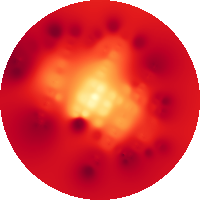

In [17]:
img_rgba_idw

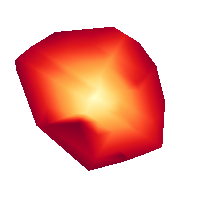

In [14]:
img_rgba_tin

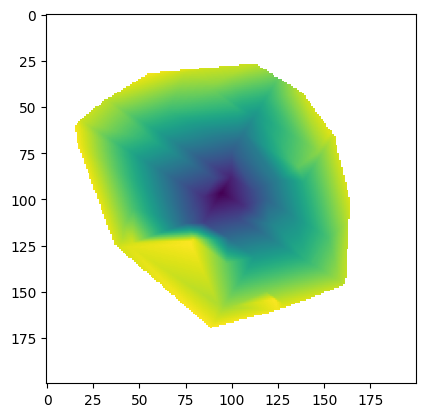

In [15]:
plt.imshow(img_singleband_tin.squeeze())

In [16]:
arr = np.array([[1,2,3,4], [2,3,4,5], [3,4,5,6]])

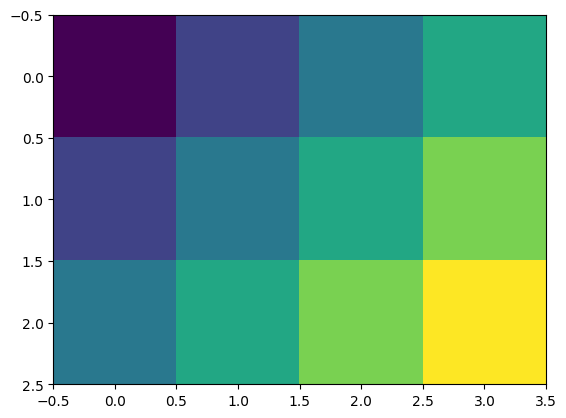

In [17]:
plt.imshow(arr)

In [18]:
arr.shape

(3, 4)

In [19]:
arr

array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6]])

In [20]:
arr.T

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

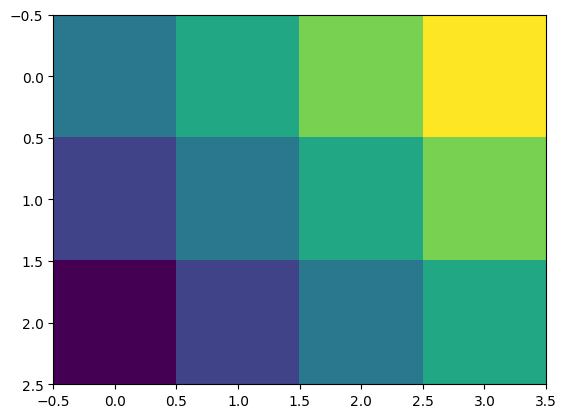

In [21]:
plt.imshow(arr[::-1])

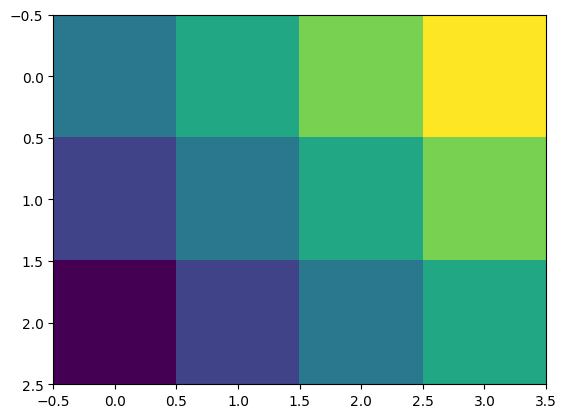

In [22]:
plt.imshow(np.flip(arr, 0))

In [23]:
A = np.arange(8).reshape((2,2,2))

In [24]:
A

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [25]:
np.flip(A, 0)

array([[[4, 5],
        [6, 7]],

       [[0, 1],
        [2, 3]]])

In [26]:
np.flip(arr, 0)

array([[3, 4, 5, 6],
       [2, 3, 4, 5],
       [1, 2, 3, 4]])